In [1]:
from __future__ import print_function, division, absolute_import
from six.moves import cPickle as pickle

In [2]:
import os, time

import numpy as np

import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

### Loading data

In [4]:
image_size = 28
pixel_depth = 255
data_root = 'data'

In [5]:
pickle_file  = os.path.join(data_root, 'notMNIST.pickle')
keys = ["{0}_{1}".format(t,x) for t in ["train","test"] for x in "Xy"]+["labels_dict"]
with open(pickle_file, 'rb') as f:
    pi = pickle.load(f)
    for k in keys:
        globals()[k] = pi[k]
print(train_X.shape, test_X.shape)

(529114, 784) (18724, 784)


In [6]:
nclasses = len(labels_dict)
labels_dict

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9}

In [7]:
def to_onehot(labels, nclasses):
    onehot = np.zeros(shape=(len(labels), nclasses))
    for i, label in enumerate(labels):
        onehot[i, int(label)] = 1
    return onehot

test_y = to_onehot(test_y, nclasses)

In [8]:
def generate_batch(batch_size=10):
    global train_X, train_y, labels_dict
    j = 0
    while 1:
        i = j
        if i+batch_size < len(train_X):
            j = i + batch_size
            raw_labels = train_y[i:i+batch_size]
            yield train_X[i:i+batch_size], to_onehot(raw_labels.flatten(), len(labels_dict))
        else:
            j = 0
            raw_labels = np.concatenate((train_y[i:], train_y[0:batch_size-(len(train_y)-i)]))
            yield np.concatenate((train_X[i:], train_X[0:batch_size-(len(train_X)-i)])),\
                    to_onehot(raw_labels.flatten(), len(labels_dict))
        

In [9]:
epochs = 100000
learning_rate = 0.1
batch_size = 100

In [10]:
g = generate_batch(batch_size)
batch_X, batch_y = g.__next__()

In [11]:
def run_session(graph):
    start = time.time()
    accuracies = dict()
    losses = dict()
    with tf.Session(graph=graph) as sess:
        with tf.device("/gpu"):
            init.run()
            print("Variables initialized")
            average_loss = 0
            for e in range(epochs+1):
                feed_dict = {train_inputs:batch_X, train_labels:batch_y}
                _, loss = sess.run([optimizer, cross_entropy], feed_dict=feed_dict)
                average_loss += np.mean(loss)
                if e%1000 == 0:
                    if e%5000 == 0:
                        print("Epoch {0}\nCross-entropy loss: {1}".format(e,average_loss/1000 if e>0 else average_loss))

                    losses[e] = average_loss
                    average_loss = 0
                    accuracy_ = sess.run([accuracy], feed_dict={test_inputs:test_X, test_labels:test_y})
                    accuracy_ = np.mean(accuracy_)
                    accuracies[e] = accuracy_
                    if e%5000==0:
                        print("Accuracy:{0}".format(accuracy_))
                        print("~"*40)
    print("Took: {}".format(time.time()-start))

    fig, ax1 = plt.subplots(figsize=(12,7))
    xticks = sorted(accuracies.keys())
    data1 = [accuracies[i] for i in xticks]
    data2 = [losses[i] for i in xticks]

    color = 'tab:blue'
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy', color=color)
    ax1.plot(xticks, data1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:red'
    ax2.set_ylabel('Cross-entropy loss', color=color)
    ax2.plot(xticks, data2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped

### No regularization

In [12]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size*image_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])

        W1 = tf.Variable(tf.random_normal(shape=[image_size*image_size, image_size*image_size], stddev=0.1))
        b1 = tf.Variable(tf.zeros(shape=[image_size*image_size]))

        h1 = tf.nn.relu(
            tf.add(tf.matmul(train_inputs, W1), b1))
        
        W2 = tf.Variable(tf.random_normal(shape=[image_size*image_size, nclasses], stddev=0.1))
        b2 = tf.Variable(tf.zeros(shape=[nclasses]))
        
        logits = tf.add(tf.matmul(h1,W2), b2)

    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))

    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size*image_size])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        h1_test = tf.nn.relu(
            tf.add(tf.matmul(test_inputs, W1), b1))
        test_logits = tf.add(tf.matmul(h1_test, W2), b2, name="test_logits")
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



Variables initialized
Epoch 0
Cross-entropy loss: 7.798101902008057
Accuracy:0.2905896306037903
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5000
Cross-entropy loss: 2.6962661768266115e-05
Accuracy:0.6717581748962402
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10000
Cross-entropy loss: 1.3984041901494493e-05
Accuracy:0.6762443780899048
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 15000
Cross-entropy loss: 9.586873541593377e-06
Accuracy:0.6791818141937256
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20000
Cross-entropy loss: 7.346904819314659e-06
Accuracy:0.6807306408882141
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25000
Cross-entropy loss: 5.985207366393297e-06
Accuracy:0.6815851330757141
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30000
Cross-entropy loss: 5.080673937754909e-06
Accuracy:0.6836680173873901
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 35000
Cross-entropy loss: 4.432022756191145e-06
Accuracy:0.6848430037498474
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
E

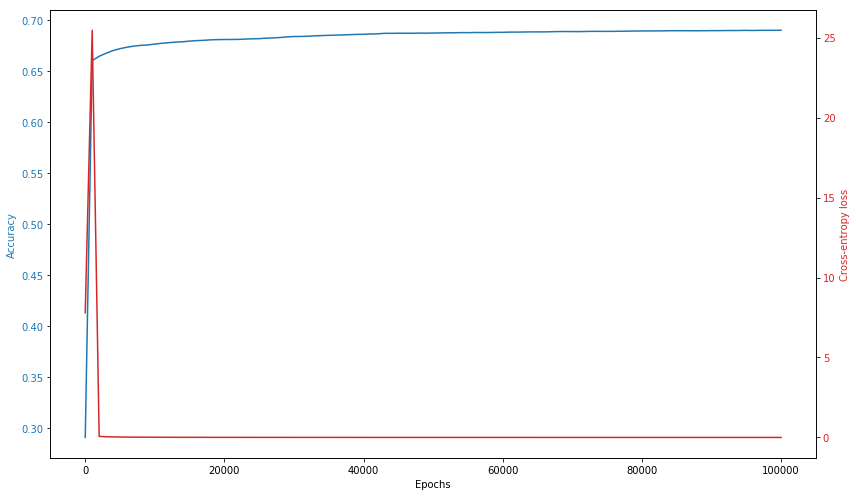

In [13]:
run_session(graph)

### With L2-regularization

In [14]:
beta = 0.1

In [15]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size*image_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])

        W1 = tf.Variable(tf.random_normal(shape=[image_size*image_size, image_size*image_size], stddev=0.1))
        b1 = tf.Variable(tf.zeros(shape=[image_size*image_size]))

        h1 = tf.nn.relu(
            tf.add(tf.matmul(train_inputs, W1), b1))
        
        W2 = tf.Variable(tf.random_normal(shape=[image_size*image_size, nclasses], stddev=0.1))
        b2 = tf.Variable(tf.zeros(shape=[nclasses]))
        
        logits = tf.add(tf.matmul(h1,W2), b2)

    with tf.name_scope("Loss"):
        cross_entropy_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))
        
    with tf.name_scope("regularization"):
        regularizer = tf.nn.l2_loss(cross_entropy_)
        cross_entropy = tf.reduce_mean(tf.add(cross_entropy_, beta*regularizer))
        
    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size*image_size])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        h1_test = tf.nn.relu(
            tf.add(tf.matmul(test_inputs, W1), b1))
        test_logits = tf.add(tf.matmul(h1_test, W2), b2, name="test_logits")
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()

Variables initialized
Epoch 0
Cross-entropy loss: 15.412561416625977
Accuracy:0.35756248235702515
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5000
Cross-entropy loss: 2.0095740332180868e-05
Accuracy:0.7240440249443054
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10000
Cross-entropy loss: 1.0180495307395177e-05
Accuracy:0.7269279956817627
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 15000
Cross-entropy loss: 6.928185994183877e-06
Accuracy:0.7284234166145325
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20000
Cross-entropy loss: 5.291554848099622e-06
Accuracy:0.729544997215271
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25000
Cross-entropy loss: 4.304154624605872e-06
Accuracy:0.730613112449646
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30000
Cross-entropy loss: 3.6491664329787452e-06
Accuracy:0.7314676642417908
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 35000
Cross-entropy loss: 3.1807391817437746e-06
Accuracy:0.731841504573822
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


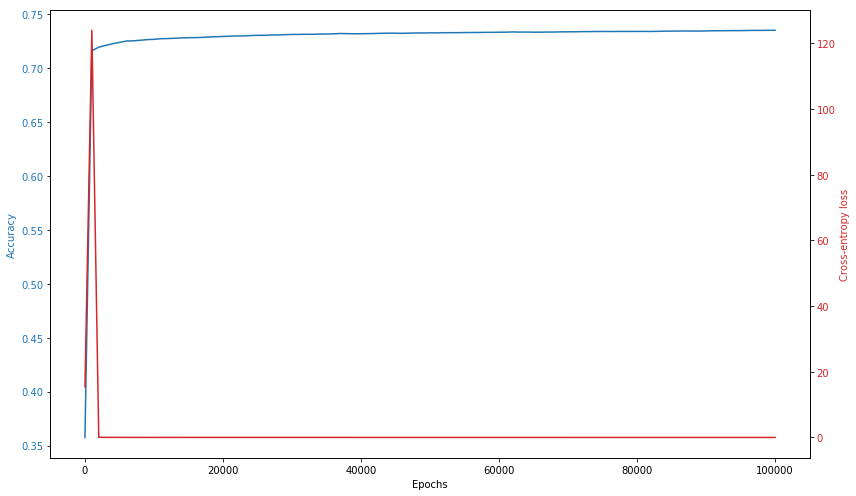

In [16]:
run_session(graph)

### Using dropout alone

In [17]:
graph = tf.Graph()

with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size*image_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])

        W1 = tf.Variable(tf.random_normal(shape=[image_size*image_size, image_size*image_size], stddev=0.1))
        b1 = tf.Variable(tf.zeros(shape=[image_size*image_size]))

        h1 = tf.nn.relu(
            tf.add(tf.matmul(train_inputs, W1), b1))
        with tf.name_scope("dropout"):
            h1_dropout = tf.nn.dropout(h1, 0.5)
        
        W2 = tf.Variable(tf.random_normal(shape=[image_size*image_size, nclasses], stddev=0.1))
        b2 = tf.Variable(tf.zeros(shape=[nclasses]))
        
        logits = tf.add(tf.matmul(h1_dropout,W2), b2)

    with tf.name_scope("Loss"):
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))
                
    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size*image_size])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        h1_test = tf.nn.relu(
            tf.add(tf.matmul(test_inputs, W1), b1))
        test_logits = tf.add(tf.matmul(h1_test, W2), b2, name="test_logits")
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()

Variables initialized
Epoch 0
Cross-entropy loss: 19.36614418029785
Accuracy:0.3210318386554718
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5000
Cross-entropy loss: 0.00017144027479748948
Accuracy:0.7286904454231262
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10000
Cross-entropy loss: 7.02920717435731e-05
Accuracy:0.7254859805107117
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 15000
Cross-entropy loss: 5.33576400865301e-05
Accuracy:0.7253257632255554
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20000
Cross-entropy loss: 5.474427209855026e-07
Accuracy:0.7282631993293762
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25000
Cross-entropy loss: 9.295289822182973e-06
Accuracy:0.7298120260238647
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30000
Cross-entropy loss: 4.7958578647677716e-06
Accuracy:0.7291176915168762
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 35000
Cross-entropy loss: 5.237493438328355e-06
Accuracy:0.7307733297348022
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epo

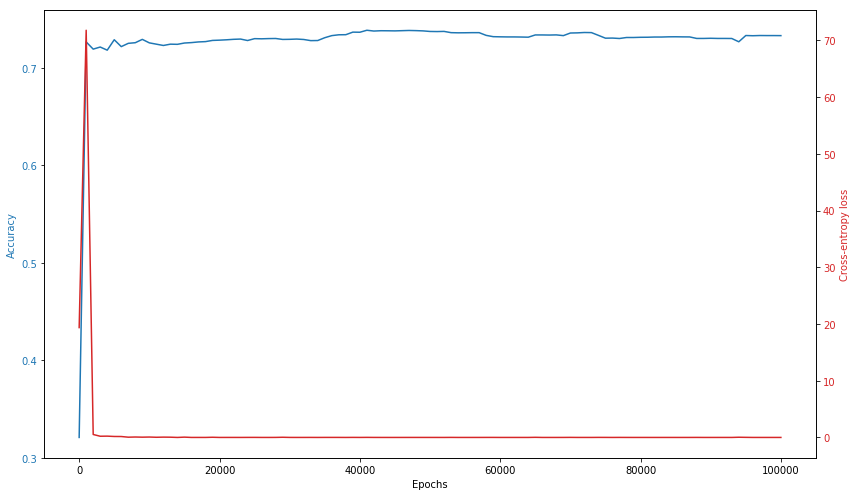

In [18]:
run_session(graph)

### Using Dropout + L2-regularization

In [25]:
graph = tf.Graph()
learning_rate = 0.01
with graph.as_default():
    with tf.name_scope("inputs"):
        train_inputs = tf.placeholder(tf.float32, shape=[batch_size, image_size*image_size])
        train_labels = tf.placeholder(tf.int32, shape=[batch_size, nclasses])

        W1 = tf.Variable(tf.random_normal(shape=[image_size*image_size, image_size*image_size], stddev=0.1))
        b1 = tf.Variable(tf.zeros(shape=[image_size*image_size]))

        h1 = tf.nn.relu(
            tf.add(tf.matmul(train_inputs, W1), b1))
        with tf.name_scope("dropout"):
            h1_dropout = tf.nn.dropout(h1, 0.5)
        
        W2 = tf.Variable(tf.random_normal(shape=[image_size*image_size, nclasses], stddev=0.1))
        b2 = tf.Variable(tf.zeros(shape=[nclasses]))
        
        logits = tf.add(tf.matmul(h1_dropout,W2), b2)

    with tf.name_scope("Loss"):
        cross_entropy_ = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_labels))
        
    with tf.name_scope("regularization"):
        regularizer = tf.nn.l2_loss(cross_entropy_)
        cross_entropy = tf.reduce_mean(tf.add(cross_entropy_, beta*regularizer))
        
    with tf.name_scope("Optimizer"):
        optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
        
    with tf.name_scope("Predictions"):
        test_inputs = tf.placeholder(tf.float32, shape=[None, image_size*image_size])
        test_labels = tf.placeholder(tf.int32, shape=[None, nclasses])
        h1_test = tf.nn.relu(
            tf.add(tf.matmul(test_inputs, W1), b1))
        test_logits = tf.add(tf.matmul(h1_test, W2), b2, name="test_logits")
        prediction_probs = tf.nn.softmax(test_logits)
        predictions = tf.argmax(prediction_probs, 1)
        
    with tf.name_scope("Accuracy"):
        target = tf.argmax(test_labels, 1)
        correct = tf.equal(predictions, target)
        accuracy = tf.reduce_mean(tf.cast(correct, "float"))
    init = tf.global_variables_initializer()

Variables initialized
Epoch 0
Cross-entropy loss: 50.55647277832031
Accuracy:0.3071993291378021
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 5000
Cross-entropy loss: 0.00163396265156675
Accuracy:0.7389980554580688
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 10000
Cross-entropy loss: 0.0008667418227792398
Accuracy:0.7379833459854126
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 15000
Cross-entropy loss: 0.00036122576884295497
Accuracy:0.7353664040565491
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 20000
Cross-entropy loss: 0.00035163714415104084
Accuracy:0.7382503747940063
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 25000
Cross-entropy loss: 0.00013292220652093013
Accuracy:0.7353129386901855
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 30000
Cross-entropy loss: 0.00026454451918940427
Accuracy:0.7371287941932678
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 35000
Cross-entropy loss: 7.727147201662298e-05
Accuracy:0.7389980554580688
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
E

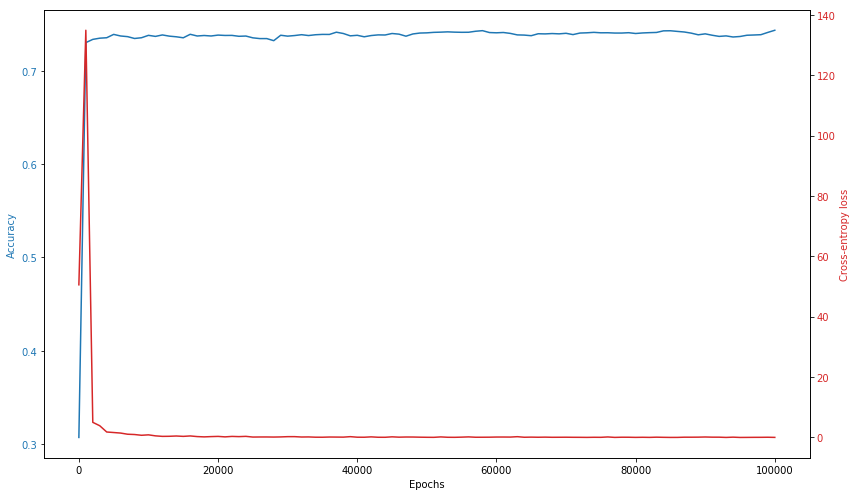

In [26]:
run_session(graph)